In [1]:
import librosa 
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal.windows import dpss
from scipy.signal import detrend
# Logistical Imports
import warnings
import timeit
from functools import partial
from multiprocessing import Pool, cpu_count
import librosa.display
import os

In [2]:
def multitaper_spectrogram(data, fs, frequency_range=None, time_bandwidth=5, num_tapers=None, window_params=None,
                           min_nfft=0, detrend_opt='linear', multiprocess=False, cpus=False, plot_on=True, verbose=True,
                           filename1 = None):
    """ Compute multitaper spectrogram of timeseries data
    Results tend to agree with Prerau Lab Matlab implementation of multitaper spectrogram with precision on the order
    of at most 10^-12 with SD of at most 10^-10
            Arguments:
                    data (1d np.array): time series data -- required
                    fs (float): sampling frequency in Hz  -- required
                    frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] (default: [0 nyquist])
                    time_bandwidth (float): time-half bandwidth product (window duration*half bandwidth of main lobe)
                                            (default: 5 Hz*s)
                    num_tapers (int): number of DPSS tapers to use (default: [will be computed
                                      as floor(2*time_bandwidth - 1)])
                    window_params (list): 1x2 list - [window size (seconds), step size (seconds)] (default: [5 1])
                    detrend_opt (string): detrend data window ('linear' (default), 'constant', 'off')
                                          (Default: 'linear')
                    min_nfft (int): minimum allowable NFFT size, adds zero padding for interpolation (closest 2^x)
                                    (default: 0)
                    multiprocess (bool): Use multiprocessing to compute multitaper spectrogram (default: False)
                    cpus (int): Number of cpus to use if multiprocess = True (default: False). Note: if default is left
                                as False and multiprocess = True, the number of cpus used for multiprocessing will be
                                all available - 1.
                    plot_on (bool): plot results (default: True)
                    verbose (bool): display spectrogram properties (default: true)
            Returns:
                    mt_spectrogram (TxF np array): spectral power matrix
                    stimes (1xT np array): timepoints (s) in mt_spectrogram
                    sfreqs (1xF np array)L frequency values (Hz) in mt_spectrogram
    """

    #  Process user input
    [data, fs, frequency_range, time_bandwidth, num_tapers,
     winsize_samples, winstep_samples, window_start,
     num_windows, nfft, detrend_opt, plot_on, verbose] = process_input(data, fs, frequency_range, time_bandwidth,
                                                                       num_tapers, window_params, min_nfft,
                                                                       detrend_opt, plot_on, verbose)

    # Set up spectrogram parameters
    [window_idxs, stimes, sfreqs, freq_inds] = process_spectrogram_params(fs, nfft, frequency_range, window_start,
                                                                          winsize_samples)
    # Display spectrogram parameters
    if verbose:
        display_spectrogram_props(fs, time_bandwidth, num_tapers, [winsize_samples, winstep_samples], frequency_range,
                                  detrend_opt)

    # Split data into segments and preallocate
    data_segments = data[window_idxs]

    # COMPUTE THE MULTITAPER SPECTROGRAM
    #     STEP 1: Compute DPSS tapers based on desired spectral properties
    #     STEP 2: Multiply the data segment by the DPSS Tapers
    #     STEP 3: Compute the spectrum for each tapered segment
    #     STEP 4: Take the mean of the tapered spectra

    # Compute DPSS tapers (STEP 1)
    DPSS_tapers = dpss(winsize_samples, time_bandwidth, num_tapers) *round( math.sqrt(fs))

    tic = timeit.default_timer()  # start timer

    # set all but 1 arg of calc_mts_segment to constant (so we only have to supply one argument later)
    calc_mts_segment_plus_args = partial(calc_mts_segment, DPSS_tapers=DPSS_tapers, nfft=nfft,
                                         freq_inds=freq_inds, detrend_opt=detrend_opt)

    if multiprocess: # use multiprocessing
        if not cpus: # if cpus not specfied, use all but 1
            pool = Pool(cpu_count()-1)
        else: # else us specified number
            pool = Pool(cpus)

        # Compute multiprocess multitaper spect.
        mt_spectrogram = pool.map(calc_mts_segment_plus_args, data_segments)
        pool.close()
        pool.join()

    else: # if no multiprocessing, compute normally
        mt_spectrogram = np.apply_along_axis(calc_mts_segment_plus_args, 1, data_segments)

    # Compute mean fft magnitude (STEP 4.2)
    mt_spectrogram = np.asarray(mt_spectrogram)
    mt_spectrogram = mt_spectrogram.conj().T / fs ** 2 / num_tapers

    # End timer and get elapsed compute time
    toc = timeit.default_timer()
    elapsed_time = toc - tic
    if verbose:
        print("\n Multitaper compute time: " + str(elapsed_time) + " seconds")

    # Plot multitaper spectrogram
    if plot_on:
        plt.figure(1, figsize=(3, 2))
        librosa.display.specshow(nanpow2db(mt_spectrogram), x_axis='time', y_axis='linear',
                                 x_coords=stimes, y_coords=sfreqs, shading='auto',
                                 cmap="jet")
        #plt.colorbar(label='Power (dB)')
        filename = 'C:/Users/DSP/Desktop/AMRITI/dev_multitapper_1/'
        filename = filename+filename1
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        

    # Put outputs into better format for output
    mt_spectrogram = mt_spectrogram.T
    stimes = np.mat(stimes)
    sfreqs = np.mat(sfreqs)

    if all(mt_spectrogram.flatten() == 0):
        print("\n Data was all zeros, no output")

    return mt_spectrogram, stimes, sfreqs

In [3]:
def process_input(data, fs, frequency_range=None, time_bandwidth=5, num_tapers=None, window_params=None, min_nfft=0,
                  detrend_opt='linear', plot_on=True, verbose=True):
    """ Helper function to process multitaper_spectrogram() arguments
            Arguments:
                    data (1d np.array): time series data-- required
                    fs (float): sampling frequency in Hz  -- required
                    frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] (default: [0 nyquist])
                    time_bandwidth (float): time-half bandwidth product (window duration*half bandwidth of main lobe)
                                            (default: 5 Hz*s)
                    num_tapers (int): number of DPSS tapers to use (default: None [will be computed
                                      as floor(2*time_bandwidth - 1)])
                    window_params (list): 1x2 list - [window size (seconds), step size (seconds)] (default: [5 1])
                    min_nfft (int): minimum allowable NFFT size, adds zero padding for interpolation (closest 2^x)
                                    (default: 0)
                    detrend_opt (string): detrend data window ('linear' (default), 'constant', 'off')
                                          (Default: 'linear')
                    plot_on (True): plot results (default: True)
                    verbose (True): display spectrogram properties (default: true)
            Returns:
                    data (1d np.array): same as input
                    fs (float): same as input
                    frequency_range (list): same as input or calculated from fs if not given
                    time_bandwidth (float): same as input or default if not given
                    num_tapers (int): same as input or calculated from time_bandwidth if not given
                    winsize_samples (float): number of samples in single time window
                    winstep_samples (float): number of samples in a single window step
                    window_start (1xm np.array): array of timestamps representing the beginning time for each window
                    num_windows (int): number of windows in the data
                    nfft (int): length of signal to calculate fft on
                    detrend_opt ('string'): same as input or default if not given
                    plot_on (bool): same as input
                    verbose (bool): same as input
    """

    # Make sure data is 1 dimensional np array
    if len(data.shape) != 1:
        if (len(data.shape) == 2) & (data.shape[1] == 1):  # if it's 2d, but can be transferred to 1d, do so
            data = np.ravel(data[:, 0])
        elif (len(data.shape) == 2) & (data.shape[0] == 1):  # if it's 2d, but can be transferred to 1d, do so
            data = np.ravel(data.T[:, 0])
        else:
            raise TypeError("Input data is the incorrect dimensions. Should be a 1d array with shape (n,) where n is \
                            the number of data points. Instead data shape was " + str(data.shape))

    # Set frequency range if not provided
    if frequency_range is None:
        frequency_range = [0, fs / 2]

    # Set detrending method
    detrend_opt = detrend_opt.lower()
    if detrend_opt != 'linear':
        if detrend_opt in ['const', 'constant']:
            detrend_opt = 'constant'
        elif detrend_opt in ['none', 'false']:
            detrend_opt = 'off'
        else:
            raise ValueError("'" + str(detrend_opt) + "' is not a valid argument for detrend_opt. The choices " +
                             "are: 'constant', 'linear', or 'off'.")
    # Check if frequency range is valid
    if frequency_range[1] > fs / 2:
        frequency_range[1] = fs / 2
        warnings.warn('Upper frequency range greater than Nyquist, setting range to [' +
                      str(frequency_range[0]) + ', ' + str(frequency_range[1]) + ']')

    # Set number of tapers if none provided
    if num_tapers is None:
        num_tapers = math.floor(2 * time_bandwidth) - 1

    # Warn if number of tapers is suboptimal
    if num_tapers != math.floor(2 * time_bandwidth) - 1:
        warnings.warn('Number of tapers is optimal at floor(2*TW) - 1. consider using ' +
                      str(math.floor(2 * time_bandwidth) - 1))

    # If no window params provided, set to defaults
    if window_params is None:
        window_params = [1, 1]

    # Check if window size is valid, fix if not
    if window_params[0] * fs % 1 != 0:
        winsize_samples = round(window_params[0] * fs)
        warnings.warn('Window size is not divisible by sampling frequency. Adjusting window size to ' +
                      str(winsize_samples / fs) + ' seconds')
    else:
        winsize_samples = window_params[0] * fs

    # Check if window step is valid, fix if not
    if window_params[1] * fs % 1 != 0:
        winstep_samples = round(window_params[1] * fs)
        warnings.warn('Window step size is not divisible by sampling frequency. Adjusting window step size to ' +
                      str(winstep_samples / fs) + ' seconds')
    else:
        winstep_samples = window_params[1] * fs

    # Get total data length
    len_data = len(data)

    # Check if length of data is smaller than window (bad)
    if len_data < winsize_samples:
        raise ValueError("\nData length (" + str(len_data) + ") is shorter than window size (" +
                         str(winsize_samples) + "). Either increase data length or decrease window size.")

    # Find window start indices and num of windows
    window_start = np.arange(0, len_data - winsize_samples + 1, winstep_samples)
    num_windows = len(window_start)

    # Get num points in FFT
    if min_nfft == 0:  # avoid divide by zero error in np.log2(0)
        nfft = max(2 ** math.ceil(np.log2(abs(winsize_samples))), winsize_samples)
    else:
        nfft = max(max(2 ** math.ceil(np.log2(abs(winsize_samples))), winsize_samples),
                   2 ** math.ceil(np.log2(abs(min_nfft))))

    return ([data, fs, frequency_range, time_bandwidth, num_tapers,
             winsize_samples, winstep_samples, window_start, num_windows, nfft,
             detrend_opt, plot_on, verbose])

In [4]:
def process_spectrogram_params(fs, nfft, frequency_range, window_start, datawin_size):
    """ Helper function to create frequency vector and window indices
        Arguments:
             fs (float): sampling frequency in Hz  -- required
             nfft (int): length of signal to calculate fft on -- required
             frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] -- required
             window_start (1xm np.array): array of timestamps representing the beginning time for each
                                          window -- required
             datawin_size (float): seconds in one window -- required
        Returns:
            window_idxs (nxm np array): indices of timestamps for each window
                                        (nxm where n=number of windows and m=datawin_size)
            stimes (1xt np array): array of times for the center of the spectral bins
            sfreqs (1xf np array): array of frequency bins for the spectrogram
            freq_inds (1d np array): boolean array of which frequencies are being analyzed in
                                      an array of frequencies from 0 to fs with steps of fs/nfft
    """

    # create frequency vector
    df = fs / nfft
    sfreqs = np.arange(df/2, fs, df)

    # Get frequencies for given frequency range
    freq_inds = (sfreqs >= frequency_range[0]) & (sfreqs <= frequency_range[1])
    sfreqs = sfreqs[freq_inds]

    # Compute times in the middle of each spectrum
    window_middle_times = window_start + round(
        datawin_size / 2)
    stimes = window_middle_times / fs

    # Get indexes for each window
    window_idxs = np.atleast_2d(window_start).T + np.arange(0, datawin_size, 1)
    window_idxs = window_idxs.astype(int)

    return [window_idxs, stimes, sfreqs, freq_inds]

In [5]:
def display_spectrogram_props(fs, time_bandwidth, num_tapers, data_window_params, frequency_range, detrend_opt):
    """ Prints spectrogram properties
        Arguments:
            fs (float): sampling frequency in Hz  -- required
            time_bandwidth (float): time-half bandwidth product (window duration*1/2*frequency_resolution) -- required
            num_tapers (int): number of DPSS tapers to use -- required
            data_window_params (list): 1x2 list - [window length(s), window step size(s)] -- required
            frequency_range (list): 1x2 list - [<min frequency>, <max frequency>] -- required
            detrend_opt (str): detrend data window ('linear' (default), 'constant', 'off')
        Returns:
            This function does not return anything
    """

    data_window_params = np.asarray(data_window_params) / fs

    # Print spectrogram properties
    #print("Multitaper Spectrogram Properties: ")
    #print('     Spectral Resolution: ' + str(2 * time_bandwidth / data_window_params[0]) + 'Hz')
    #print('     Window Length: ' + str(data_window_params[0]) + 's')
    #print('     Window Step: ' + str(data_window_params[1]) + 's')
    #print('     Time Half-Bandwidth Product: ' + str(time_bandwidth))
    #print('     Number of Tapers: ' + str(num_tapers))
    #print('     Frequency Range: ' + str(frequency_range[0]) + "-" + str(frequency_range[1]) + 'Hz')
    #print('     Detrend: ' + detrend_opt + '\n')

In [6]:
def nanpow2db(y):
    """ Power to dB conversion, setting bad values to nans
        Arguments:
            y (float or array-like): power
        Returns:
            ydB (float or np array): inputs converted to dB with 0s and negatives resulting in nans
    """

    if isinstance(y, int) or isinstance(y, float):
        if y == 0:
            return np.nan
        else:
            ydB = 10 * np.log10(y)
    else:
        if isinstance(y, list):  # if list, turn into array
            y = np.asarray(y)
        y = y.astype(float)  # make sure it's a float array so we can put nans in it
        y[y == 0] = np.nan
        ydB = 10 * np.log10(y)

    return ydB

In [7]:
def calc_mts_segment(data_segment, DPSS_tapers, nfft, freq_inds, detrend_opt):
    """ Helper function to calculate the multitaper spectrum of a single segment of data
        Arguments:
            data_segment (1d np.array): One window worth of time-series data -- required
            DPSS_tapers (2d np.array): Parameters for the DPSS tapers to be used.
                                       Dimensions are (num_tapers, winsize_samples) -- required
            nfft (int): length of signal to calculate fft on -- required
            freq_inds (1d np array): boolean array of which frequencies are being analyzed in
                                      an array of frequencies from 0 to fs with steps of fs/nfft
            detrend_opt (str): detrend data window ('linear' (default), 'constant', 'off')
        Returns:
            mt_spectrum (1d np.array): spectral power for single window
    """

    # If segment has all zeros, return vector of zeros
    if all(data_segment == 0):
        ret = np.empty(sum(freq_inds))
        ret.fill(0)
        return ret

    # Option to detrend data to remove low frequency DC component
    if detrend_opt != 'off':
        data_segment = detrend(data_segment, type=detrend_opt)

    # Multiply data by dpss tapers (STEP 2)
    tapered_data = np.multiply(np.mat(data_segment).T, np.mat(DPSS_tapers.T))

    # Compute the FFT (STEP 3)
    fft_data = np.fft.fft(tapered_data, nfft, axis=0)
    fft_range = fft_data[freq_inds, :]

    # Take the FFT magnitude (STEP 4.1)
    magnitude = np.power(np.imag(fft_range), 2) + np.power(np.real(fft_range), 2)
    mt_spectrum = np.sum(magnitude, axis=1)

    return mt_spectrum

<ipython-input-3-b293b94ccf38>:71: UserWarning: Number of tapers is optimal at floor(2*TW) - 1. consider using 9
  warnings.warn('Number of tapers is optimal at floor(2*TW) - 1. consider using ' +



 Multitaper compute time: 0.17432339999959368 seconds

 Multitaper compute time: 0.18041249999987485 seconds

 Multitaper compute time: 0.20419289999972534 seconds

 Multitaper compute time: 0.0288897000000361 seconds

 Multitaper compute time: 0.0872466999999233 seconds

 Multitaper compute time: 0.16228159999991476 seconds

 Multitaper compute time: 0.06269069999962085 seconds

 Multitaper compute time: 0.11462599999958911 seconds

 Multitaper compute time: 0.07864380000046367 seconds

 Multitaper compute time: 0.08359389999986888 seconds

 Multitaper compute time: 0.09026480000011361 seconds

 Multitaper compute time: 0.08895529999972496 seconds

 Multitaper compute time: 0.10910400000011578 seconds

 Multitaper compute time: 0.12823060000027908 seconds

 Multitaper compute time: 0.10148200000003271 seconds

 Multitaper compute time: 0.08986989999993966 seconds

 Multitaper compute time: 0.13008280000030936 seconds

 Multitaper compute time: 0.12203020000015385 seconds

 Multitaper

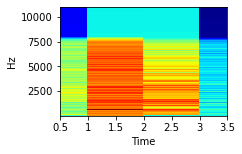

In [11]:
path = 'C:/Users/DSP/Desktop/AMRITI/dev/'
for file_ in os.listdir(path)[21410:21501]:
    X, sr = librosa.load(os.path.join(path + file_))
    multitaper_spectrogram(X, sr, frequency_range=None, time_bandwidth=5, num_tapers=5, 
                       window_params=None, min_nfft=0, detrend_opt='linear', multiprocess=False, 
                       cpus=False, plot_on=True, verbose=True, filename1 = file_.split('.')[0]+'.png')


<ipython-input-3-b293b94ccf38>:71: UserWarning: Number of tapers is optimal at floor(2*TW) - 1. consider using 9
  warnings.warn('Number of tapers is optimal at floor(2*TW) - 1. consider using ' +



 Multitaper compute time: 0.15710370000033436 seconds


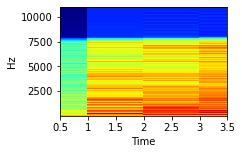

In [12]:
path = 'C:/Users/DSP/Desktop/AMRITI/dev/'
for file_ in os.listdir(path)[0:1]:
    X, sr = librosa.load(os.path.join(path + file_))
    multitaper_spectrogram(X, sr, frequency_range=None, time_bandwidth=5, num_tapers=5, 
                       window_params=None, min_nfft=0, detrend_opt='linear', multiprocess=False, 
                       cpus=False, plot_on=True, verbose=True, filename1 = file_.split('.')[0]+'.png')


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
%matplotlib inline

In [24]:
c = 0
for folder in os.listdir('check'):
    for filename in os.listdir('check' + '/' + folder):
        image = Image.open('check' + '/' + folder + '/' + filename)
        width, height = image.size  
        left = width / 7
        top = height / height
        right = width
        bottom = 6 * height/9
        image = image.crop((left, top, right, bottom))
        image = image.resize((600,400))
        if c == 0:
            name = filename.split('.')[0]+'.png'
            image = image.save('data_cropped/0/'+name)
        if c == 1:
            name = filename.split('.')[0]+'.png'
            image = image.save('data_cropped/1/'+name)
        if c == 2:
            name = filename.split('.')[0]+'.png'
            image = image.save('data_cropped/2/'+name)
        if c == 3:
            name = filename.split('.')[0]+'.png'
            image = image.save('data_cropped/3/'+name)
       
    c = c + 1